# Project Overview

Our goal in this project is to predict the probability that the transaction of a new user is fraudulent.

1. Determine each user‘s country based on the ip address
2. Different assumption of the cost in terms of the false negative and false positive leads to different impact on the model
3. Model interpretation e.g. why is the user's transaction is fraudulent and what kind of user is highly considered to be a scam?

# Load Package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
import time

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


# Import Data

In [4]:
# Import and store dataset
fraud_data = pd.read_csv('imbalancedFraudDF.csv')
ipToCountry = pd.read_csv('IpAddress_to_Country.csv')

In [5]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [6]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
type(ipToCountry['upper_bound_ip_address'][0])

numpy.int64

## Join this two dataset together

In [8]:
## Method 1
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']#number
    #below [] is list of T/F, tmp is a df of size n * 3, n = len(tmp) is 1 match or 0 no match
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')
        
fraud_data['country'] = countries
print("Lookup took", time.time() - start, "seconds.")

Lookup took 331.37028884887695 seconds.


In [9]:
## Method 2
target = ipToCountry[['lower_bound_ip_address','upper_bound_ip_address']]

In [10]:
print('There are total', fraud_data['country'].nunique(), 'country in the dataset including NA')

There are total 181 country in the dataset including NA


# Data Exploration

## Big Overview

In [5]:
import pandas_profiling

#Inline summary report without saving report as object
pandas_profiling.ProfileReport(fraud_data)

#simpler version without installing pandas_profiling
# fraud_data.describe().transpose()

# will give warnings on missing, correlation, constant value(0 variance), etc, see http://nbviewer.jupyter.org/github/JosPolfliet/pandas-profiling/blob/master/examples/meteorites.ipynb

From above:

1. Notice that user_id is also a categorical features and the signup_time and purchase_time can be treated as numerical features. 
2. Can't tell much difference for ip_address vs. class
3. purchase_value and age is more spread out when class is 0.
4. I don't see a correlation among these three variable

Transformation:

1. Transform the signup_time and purchase_time into difference


In [11]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [12]:
print(len(fraud_data.user_id.unique()))#138289
print(len(fraud_data.index))#138376
#most of the user_id has only the first 1 transaction, difficult to do time based aggregates, 
#e.g. amount/counts in past 1 day for this user

138376
138376


## More on Label Column 

Data is highly imbalanced. The fraud label is only 1.02%.

In [13]:
#Distribution of the label column
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [14]:
#Distribution of the label column
fraud_data['class'].value_counts() / fraud_data['class'].value_counts().sum()

0    0.989774
1    0.010226
Name: class, dtype: float64

## Feature Engineering

### Numerical Features

Transform the signup_time and purchase_time into difference

In [15]:
#time related features: can be done before split, as they has no interaction between other rows, solely based on other columns of the same row
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

#bed time operation
fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

#fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)

In [16]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


In [17]:
print("The ealiest sign up date:", min(fraud_data['signup_time']))
print("The latest sign up date:", max(fraud_data['signup_time']))

The ealiest sign up date: 2015-01-01 0:00:42
The latest sign up date: 2015-08-18 4:40:29


In [18]:
print("The ealiest purchase date:", min(fraud_data['purchase_time']))
print("The latest purchase date:", max(fraud_data['purchase_time']))

The ealiest purchase date: 2015-01-01 0:00:47
The latest purchase date: 2015-12-16 2:56:05


### Categorical Features

1. About 40% of the user comes from search engine and 39% of the user comes from ads. Makes sense since search engine represents ads in their page.
2. About 40% of the user are using Chrome.
3. About 58% of the user are male.
4. There are some users are sharing device.

#### Categorical Features little exploration

In [238]:
print(fraud_data.select_dtypes(['object']).head())

           signup_time        purchase_time      device_id source browser sex  \
0  2015-02-24 22:55:49   2015-04-18 2:47:11  QVPSPJUOCKZAR    SEO  Chrome   M   
1  2015-06-07 20:39:50   2015-06-08 1:38:54  EOGFQPIZPYXFZ    Ads  Chrome   F   
2  2015-04-28 21:13:25  2015-05-04 13:54:50  ATGTXKYKUDUQN    SEO  Safari   M   
3   2015-07-21 7:09:52  2015-09-09 18:40:53  NAUITBZFJKHWW    Ads  Safari   M   
4   2015-05-21 6:03:03   2015-07-09 8:05:14  ALEYXFXINSXLZ    Ads  Chrome   M   

         country  
0          Japan  
1  United States  
2             NA  
3  United States  
4         Canada  


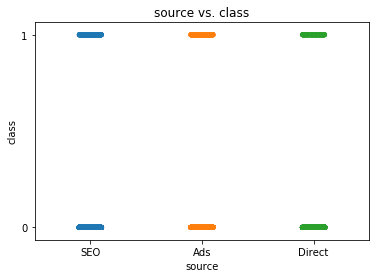

SEO       0.403003
Ads       0.396839
Direct    0.200158
Name: source, dtype: float64


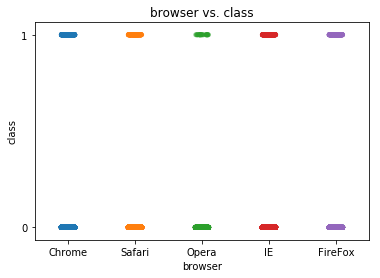

Chrome     0.404644
IE         0.244522
Safari     0.163829
FireFox    0.162600
Opera      0.024405
Name: browser, dtype: float64


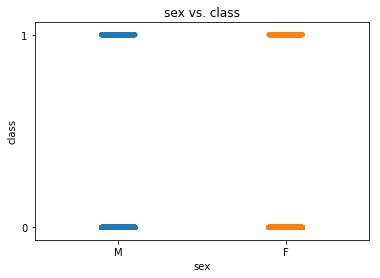

M    0.583143
F    0.416857
Name: sex, dtype: float64


In [20]:
#better way to plot?
sns.stripplot(x = 'source', y = 'class', data = fraud_data, jitter = True, alpha = 0.5)
plt.title('source vs. class')
plt.yticks(np.arange(0, 1.1))
plt.show()
print(fraud_data['source'].value_counts() / (fraud_data['source'].value_counts().sum()))

sns.stripplot(x = 'browser', y = 'class', data = fraud_data, jitter = True, alpha = 0.5)
plt.title('browser vs. class')
plt.yticks(np.arange(0, 1.1))
plt.show()
print(fraud_data['browser'].value_counts() / (fraud_data['browser'].value_counts().sum()))

sns.stripplot(x = 'sex', y = 'class', data = fraud_data, jitter = True, alpha = 0.5)
plt.title('sex vs. class')
plt.yticks(np.arange(0, 1.1))
plt.show()
print(fraud_data['sex'].value_counts() / (fraud_data['sex'].value_counts().sum()))

In [239]:
print("The number of unique device_id:", fraud_data['device_id'].nunique())
print("The number of unique user_id:", fraud_data['user_id'].nunique())

The number of unique device_id: 134121
The number of unique user_id: 138376


#### Train Test Split

In [272]:
fraud_y = fraud_data['class']
fraud_X = fraud_data.drop(['user_id', 'class', 'signup_time', 'purchase_time'], axis=1)

#split into train/test
fraud_X_train, fraud_X_test, fraud_y_train, fraud_y_test = train_test_split(fraud_X, fraud_y, test_size = 0.2, random_state = 0)
print("X_train.shape:", fraud_X_train.shape)
print("y_train.shape:", fraud_y_train.shape)


X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [273]:
fraud_X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
29343,12,OULPAZAFRFPXP,Ads,Chrome,M,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648
12190,10,AIIWMFEYQQIEB,Ads,Opera,M,29,1.686759e+09,United States,6766039.0,5,78146,84,18585
19388,34,VUVETBUPCIWJE,Direct,Chrome,M,53,4.138429e+09,NA,5870515.0,197,81354,265,76669
89104,48,QCFULAJOYKFUU,Ads,Chrome,M,29,9.617337e+07,France,2145618.0,160,30920,185,16538
82082,44,IHRWLMIJMEEEU,Ads,FireFox,M,24,1.936025e+09,China,7079059.0,111,71897,193,66156


#### One-Hot Encoding

1. We assume that the more a device is shared, the more suspicious
2. We assume that the more a ip is shared, the more suspicious
3. We assume that the less visit from a country, the more suspicious

In [274]:
fraud_easy_dummy = ["source", "browser", "sex"]
fraud_X_train = pd.get_dummies(fraud_X_train, prefix_sep = "_", columns = fraud_easy_dummy)

In [275]:
fraud_X_train_device_id_mapping = fraud_X_train.device_id.value_counts(dropna = False)
fraud_X_train['n_dev_shared'] = fraud_X_train.device_id.map(fraud_X_train_device_id_mapping)
print(fraud_X_train['device_id'].nunique())
X_train_devide_id = set(fraud_X_train['device_id'])

107963


In [276]:
fraud_X_train_ip_address_mapping = fraud_X_train.ip_address.value_counts(dropna = False)
fraud_X_train['n_ip_shared'] = fraud_X_train.ip_address.map(fraud_X_train_ip_address_mapping)
print(fraud_X_train['ip_address'].nunique())
X_train_ip_address = set(fraud_X_train['ip_address'])

110212


In [277]:
fraud_X_train_country_mapping = fraud_X_train.country.value_counts(dropna=False)
fraud_X_train['n_country_shared'] = fraud_X_train.country.map(fraud_X_train_country_mapping)#lots of NAs in country column, #without dropna=False will produce nan in this col
print(fraud_X_train['country'].nunique())
X_train_country = set(fraud_X_train['country'])

176


In [278]:
fraud_X_train = fraud_X_train.drop(['device_id','ip_address','country'], axis=1)
fraud_X_train.head()

,purchase_value,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,n_dev_shared,n_ip_shared,n_country_shared
29343,12,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,0,1,1,1,3051
12190,10,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,0,1,1,1,42221
19388,34,53,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0,0,1,1,1,16740
89104,48,29,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0,0,1,1,1,2317
82082,44,24,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0,0,1,1,1,8749


1. Notice that "source", "browser", "sex" has the same level with train data, so we can direcly do the OHE
2. Notice that "device_id", "ip_address", "country" has different level with the train data, and in order to keep all the information, we do the test OHE se

In [279]:
fraud_X_test = pd.get_dummies(fraud_X_test, prefix_sep = "_", columns = fraud_easy_dummy)

In [280]:
print("The number of unique device_id in train set:", fraud_X_test['device_id'].nunique())
X_test_device_id = set(fraud_X_test['device_id'])
print("The number of non-overlap device_id in the test set:", len(X_test_device_id - X_train_devide_id))

The number of unique device_id in train set: 27501
The number of non-overlap device_id in the test set: 26158


In [281]:
fraud_X_test['n_ip_shared'] = fraud_X_test.ip_address.map(fraud_X_test.ip_address.value_counts(dropna=False))

In [282]:
print("The number of unique ip_address in train set:", fraud_X_test['ip_address'].nunique())
X_test_ip_address = set(fraud_X_test['ip_address'])
print("The number of non-overlap ip_address in the test set:", len(X_test_ip_address - X_train_ip_address))

The number of unique ip_address in train set: 27642
The number of non-overlap ip_address in the test set: 27440


In [283]:
fraud_X_test['n_dev_shared'] = fraud_X_test.device_id.map(fraud_X_test.device_id.value_counts(dropna=False))

In [284]:
print("The number of unique country in train set:", fraud_X_test['country'].nunique())
X_test_country = set(fraud_X_test['country'])
print("The number of non-overlap unique country in test set:", len(X_test_country - X_train_country))

The number of unique country in train set: 154
The number of non-overlap unique country in test set: 5


In [285]:
fraud_X_test['n_country_shared'] = fraud_X_test.country.map(fraud_X_train_country_mapping)

In [286]:
fraud_X_test = fraud_X_test.drop(['device_id','ip_address','country'], axis=1)

In [287]:
fraud_X_test.head()

,purchase_value,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,n_ip_shared,n_dev_shared,n_country_shared
10224,19,34,4311302.0,190,36985,240,28287,1,0,0,0,0,0,0,1,0,1,1,1,16740.0
85132,31,41,4079557.0,75,48284,122,67041,1,0,0,1,0,0,0,0,1,0,1,1,16740.0
45717,29,30,6104979.0,58,68033,129,38612,1,0,0,1,0,0,0,0,0,1,1,1,1323.0
62898,74,27,5206591.0,135,42763,195,65354,0,0,1,0,0,1,0,0,1,0,1,1,42221.0
6553,39,35,292543.0,201,59280,205,6223,0,1,0,0,0,1,0,0,1,0,1,1,5226.0


In [288]:
# # normalize (min-max) to [0,1], standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so we do normalize here

# needs to be brought to the same scale for models like LR with regularization(that are not tree based)

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(fraud_X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']]) 
#print(scaler.data_max_)

#transform the training data and use them for the model training
fraud_X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(fraud_X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above on X_test, not fitting a brandnew scaler on test
fraud_X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(fraud_X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])


### Numerical Features after Feature Engineering

New information after feature engineering:

1. Still don't see big difference in the new numerical feature scatterplot
2. There is strong relationship between interval after signup and purchase days of years. It makes sense since long interval after signup date indicates later purchase days in the same year.
3. n_country_shared and n_device_shared has a relatively positive high relationship. This is quite interesting and it indicates that the more country shared the more deviced being shared and it matched our common sense that in this situation, it is more likely to have a fraudulent transaction. 
4. For n_device_shared and n_ip_shared, X_train has 1-6 values and X_test has 1-3 values.
5. United States        0.381400

   NA                   0.151220
   
   China                0.079033
   
   Japan                0.047209
   
   United Kingdom       0.029286
   
   Korea Republic of    0.027561
   

In [289]:
print(fraud_X_train.select_dtypes(['number']).head())

       purchase_value  age  interval_after_signup  signup_days_of_year  \
29343              12   42              3499664.0                  183   
12190              10   29              6766039.0                    5   
19388              34   53              5870515.0                  197   
89104              48   29              2145618.0                  160   
82082              44   24              7079059.0                  111   

       signup_seconds_of_day  purchase_days_of_year  purchase_seconds_of_day  \
29343                  67384                    224                    24648   
12190                  78146                     84                    18585   
19388                  81354                    265                    76669   
89104                  30920                    185                    16538   
82082                  71897                    193                    66156   

       source_Ads  source_Direct  source_SEO  browser_Chrome  browser_Fire

In [290]:
fraud_X_train.select_dtypes(['number']).columns

Index(['purchase_value', 'age', 'interval_after_signup', 'signup_days_of_year',
       'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared'],
      dtype='object')

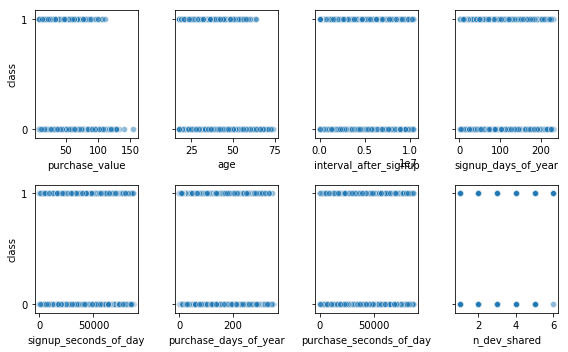

In [40]:
fraud_num = ['purchase_value', 'age', "interval_after_signup", "signup_days_of_year", 
            "signup_seconds_of_day", "purchase_days_of_year", "purchase_seconds_of_day", "n_dev_shared"]
index = 0

fig, axes = plt.subplots(2,4, figsize=(8,5), sharey = True)
axes = axes.flatten()
for ax in axes:
    sns.scatterplot(fraud_X_train[fraud_num[index]], fraud_y_train, ax = ax, alpha = 0.5)
    plt.yticks(np.arange(0, 1.1))
    index += 1

plt.tight_layout()  
plt.show()

In [291]:
tmp1 = fraud_X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']].describe()
tmp2 = fraud_X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']].describe()
tmp3 = [tmp1, tmp2]
pd.concat(tmp3)

,n_dev_shared,n_ip_shared,n_country_shared
count,110700.000000,110700.000000,110700.000000
mean,0.010847,0.002515,0.475580
std,0.052852,0.032828,0.428677
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.054856
50%,0.000000,0.000000,0.396471
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000
count,27676.000000,27676.000000,27670.000000
mean,0.002587,0.000549,0.478243


In [292]:
print(fraud_X_train.n_ip_shared.value_counts())
print(fraud_X_test.n_ip_shared.value_counts())

0.0    109882
0.2       426
0.4       252
0.6       104
0.8        30
1.0         6
Name: n_ip_shared, dtype: int64
0.0    27612
0.2       52
0.4       12
Name: n_ip_shared, dtype: int64


In [293]:
print(fraud_X_train.n_dev_shared.value_counts())
print(fraud_X_test.n_dev_shared.value_counts())

0.0    105427
0.2      4774
0.4       324
0.6       124
0.8        45
1.0         6
Name: n_dev_shared, dtype: int64
0.0    27330
0.2      334
0.4       12
Name: n_dev_shared, dtype: int64


In [294]:
(fraud_X_train_country_mapping / (fraud_X_train_country_mapping.sum())).head(6)

United States        0.381400
NA                   0.151220
China                0.079033
Japan                0.047209
United Kingdom       0.029286
Korea Republic of    0.027561
Name: country, dtype: float64

Text(0.5, 1.0, 'Train Correlation')

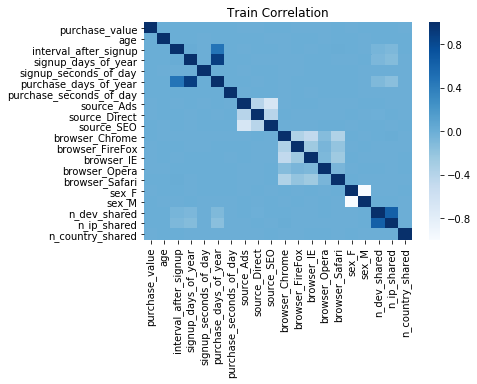

In [295]:
fraud_X_train_corr = ['purchase_value', 'age', 'interval_after_signup',
       'signup_days_of_year', 'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared']
sns.heatmap(fraud_X_train[fraud_X_train_corr].corr(), cmap = "Blues")
plt.title("Train Correlation")

Text(0.5, 1.0, 'Test Correlation')

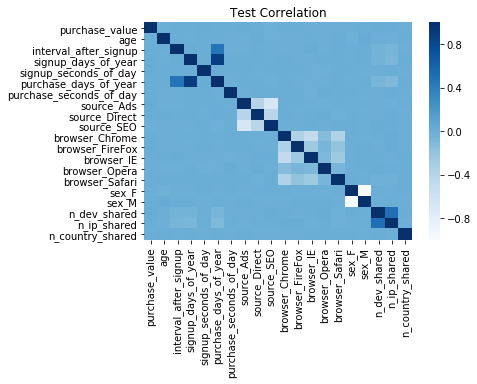

In [296]:
fraud_X_test_corr = ['purchase_value', 'age', 'interval_after_signup',
       'signup_days_of_year', 'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared']
sns.heatmap(fraud_X_test[fraud_X_test_corr].corr(), cmap = "Blues")
plt.title("Test Correlation")

# Model

In [297]:
def recall(confusion_matrix):
    return float(confusion_matrix[1,1])/(confusion_matrix[1,0] + confusion_matrix[1,1])

In [298]:
def precision(confusion_matrix):
    return float(confusion_matrix[1,1])/(confusion_matrix[1,1] + confusion_matrix[0,1])

## Logistic Regression

1. Since there is 6 rows of missing in the test, we just dropped this 6 rows in order to fit logistic regression.
2. Using default logistic regression, due to the imbalanced data, the tp is 0, that is, the model can't predict any fradulent transaction.

In [299]:
logreg = LogisticRegression()

logreg.fit(fraud_X_train, fraud_y_train)

model_fraud_X_test = fraud_X_test.dropna()
model_fraud_y_test = fraud_y_test.drop(list(fraud_y_test[fraud_X_test['n_country_shared'].isna()].index))

logreg_fraud_y_probs = logreg.predict_proba(model_fraud_X_test)
logreg_fraud_y_pred = logreg.predict(model_fraud_X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [300]:
print ("confusion_matrix is: ")
logreg_cm = confusion_matrix(model_fraud_y_test, logreg_fraud_y_pred)
logreg_cmDF = pd.DataFrame(logreg_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF)

print("%s: %r" % ("\nroc_auc_score is", roc_auc_score(model_fraud_y_test, logreg_fraud_y_probs[:, 1])))

print("%s: %r" % ("accuracy_score is", accuracy_score(model_fraud_y_test, logreg_fraud_y_pred)))
print("recall_score is:", recall(logreg_cm))
print("precision_score is:", precision(logreg_cm))
print("%s: %r" % ("f1_score is", f1_score(model_fraud_y_test, logreg_fraud_y_pred)))

confusion_matrix is: 
        pred_0  pred_1
true_0   27383       0
true_1     287       0

roc_auc_score is: 0.6948761795671441
accuracy_score is: 0.9896277556920853
recall_score is: 0.0
precision_score is: nan
f1_score is: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [301]:
rf = RandomForestClassifier(random_state = 0)

rf.fit(fraud_X_train, fraud_y_train)

rf_fraud_y_pred = rf.predict(model_fraud_X_test)

rf_fraud_y_probs = rf.predict_proba(model_fraud_X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [302]:
# generate evaluation metrics
print ("confusion_matrix is: ")
rf_cm = confusion_matrix(model_fraud_y_test, rf_fraud_y_pred)
rf_cmDF = pd.DataFrame(rf_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF)

print("%s: %r" % ("\nroc_auc_score is", roc_auc_score(model_fraud_y_test, rf_fraud_y_probs[:, 1])))

print("%s: %r" % ("accuracy_score is", accuracy_score(model_fraud_y_test, rf_fraud_y_pred)))
print("recall_score is:", recall(rf_cm))
print("precision_score is:", precision(rf_cm))
print("%s: %r" % ("f1_score is", f1_score(model_fraud_y_test, rf_fraud_y_pred)))

confusion_matrix is: 
        pred_0  pred_1
true_0   27382       1
true_1     142     145

roc_auc_score is: 0.7570649329596264
accuracy_score is: 0.9948319479580774
recall_score is: 0.5052264808362369
precision_score is: 0.9931506849315068
f1_score is: 0.6697459584295612


In [311]:
pd.DataFrame(rf.feature_importances_, index = fraud_X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


,importance
interval_after_signup,0.418699
purchase_days_of_year,0.172837
signup_seconds_of_day,0.071468
purchase_seconds_of_day,0.070911
signup_days_of_year,0.066059
purchase_value,0.042405
n_ip_shared,0.039650
age,0.037089
n_country_shared,0.028419
n_dev_shared,0.009062


## XGBoost

In [57]:
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state = 0)
xgboost.fit(fraud_X_train, fraud_y_train)

rearr_col = ['purchase_value', 'age', 'interval_after_signup', 'signup_days_of_year',
       'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared']
xgb_fraud_X_test = model_fraud_X_test[rearr_col]

xgb_fraud_y_pred = xgboost.predict(xgb_fraud_X_test)
xgb_fraud_y_probs = xgboost.predict_proba(xgb_fraud_X_test)

In [54]:
xgb_cm = confusion_matrix(model_fraud_y_test, xgb_fraud_y_pred)
xgb_cmDF = pd.DataFrame(xgb_cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(xgb_cmDF)

print("%s: %r" % ("\nroc_auc_score is", roc_auc_score(model_fraud_y_test, xgb_fraud_y_probs[:, 1])))

print("%s: %r" % ("accuracy_score is", accuracy_score(model_fraud_y_test, xgb_fraud_y_pred)))
print("recall_score is:", recall(xgb_cm))
print("precision_score is:", precision(xgb_cm))
print("%s: %r" % ("f1_score is", f1_score(model_fraud_y_test, xgb_fraud_y_pred)))

        pred_0  pred_1
true_0   27383       0
true_1     142     145

roc_auc_score is: 0.7964113012460616
accuracy_score is: 0.9948680881821468
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: 0.6712962962962962


# SMOTE

In [74]:
#Wrong way to sampling: smote before split train/test, then test data does not reflect true distribution in reality, 
#and “blend” information from the test set into the training of the model. overfit! think about the case of simple 
#oversampling (where I just duplicate observations). If I upsample a dataset before splitting it into a train and 
#validation set, I could end up with the same observation in both datasets

#https://imbalanced-learn.org/en/stable/install.html

# Install
# imbalanced-learn is currently available on the PyPi’s reporitories and you can install it via pip:

# pip install -U imbalanced-learn

#oversampling on only the training data, the right way! 
#sampling_strategy = number of samples in the majority class over the number of samples in the minority class after resampling

smote = SMOTE(random_state = 0)
fraud_X_train_sm, fraud_y_train_sm = smote.fit_sample(fraud_X_train, fraud_y_train)

unique, counts = np.unique(fraud_y_train_sm, return_counts = True)

print("The label after SMOTE is:\n",np.asarray((unique, counts)))


The label after SMOTE is:
 [[     0      1]
 [109572 109572]]


# Hyperparameter Tuning

In [103]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label = 1)
}

In [320]:
def grid_search_wrapper(X_train, y_train, X_test, y_test,
                        model_name, model, parameters, k, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(model, parameters, scoring = scorers, refit = refit_score,
                               cv = k, return_train_score = True)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    print('\nConfusion matrix of', model_name, 'optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("%s: %r" % ("accuracy_score is", accuracy_score(y_test, y_pred)))
    print("recall_score is:", recall(cm))
    print("precision_score is:", precision(cm))
    print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))

    return grid_search

In [116]:
def grid_search_wrapper_smote(X_train, y_train, X_test, y_test,
                        model_name, pipeline, parameters, k, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """
    smote = SMOTE(random_state = 0)
    grid_search = GridSearchCV(pipeline, parameters, scoring = scorers, refit = refit_score,
                               cv = k, return_train_score = True)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    print('\nConfusion matrix of', model_name, 'optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("%s: %r" % ("accuracy_score is", accuracy_score(y_test, y_pred)))
    print("recall_score is:", recall(cm))
    print("precision_score is:", precision(cm))
    print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))

    return grid_search

## Logistic Regression

### Without SMOTE

In [570]:
# C: inverse of regularization strength, smaller values specify stronger regularization
LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
LR_CV = LogisticRegression(random_state = 0)

grid_search_LR_f1 = grid_search_wrapper(fraud_X_train, fraud_y_train, 
                                        model_fraud_X_test, model_fraud_y_test,
                                        "Logistic Regression", LR_CV, 
                                        LRGrid, 3, refit_score = 'f1_score')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Fram

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Fram

Best params for f1_score
{'C': 0.1, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27380       3
true_1     278       9
roc_auc_score is: : 0.756761010830876
accuracy_score is: 0.9898445970365016
recall_score is: 0.0313588850174216
precision_score is: 0.75
f1_score is: : 0.06020066889632108


### With SMOTE

In [117]:
LR_CV = LogisticRegression(random_state = 0)

LRGrid = {"class__C" : np.logspace(-2,2,5), "class__penalty":["l1","l2"]}

LR_pipeline = Pipeline([('sampling', smote), ('class', LR_CV)])

grid_search_LR_f1_sm = grid_search_wrapper_smote(fraud_X_train, fraud_y_train, 
                                        model_fraud_X_test, model_fraud_y_test,
                                        "Logistic Regression", LR_pipeline, 
                                        LRGrid, 3, refit_score = 'f1_score')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Best params for f1_score
{'class__C': 0.01, 'class__penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27095     288
true_1     234      53
roc_auc_score is: : 0.7521577071458029
accuracy_score is: 0.9811348030357788
recall_score is: 0.18466898954703834
precision_score is: 0.15542521994134897
f1_score is: : 0.16878980891719747


## Random Forest

### Without SMOTE

In [321]:
rfGrid = {        
'max_depth': [None, 10, 15],
'min_samples_split': np.arange(5, 25, 5),
'n_estimators' :  np.arange(5, 20, 2),
'class_weight' : [{0: 1, 1: w} for w in [0.01, 0.1, 0.2, 1]]
}

rf_CV = RandomForestClassifier(random_state = 0)
grid_search_rf_f1 = grid_search_wrapper(fraud_X_train, fraud_y_train, 
                                        model_fraud_X_test, model_fraud_y_test,
                                        "Random Forest", rf_CV, 
                                        rfGrid, 3, refit_score = 'f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.01}, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 5}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27383       0
true_1     142     145
roc_auc_score is: : 0.7534751908054553
accuracy_score is: 0.9948680881821468
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


In [323]:
rfGrid = {        
'max_depth': [None, 10, 15],
'min_samples_split': np.arange(5, 25, 5),
'n_estimators' :  np.arange(5, 20, 2),
'class_weight' : [{0: 1, 1: w} for w in [0.01, 0.1, 0.2, 1]]
}

rf_CV = RandomForestClassifier(random_state = 0)
grid_search_rf_f1 = grid_search_wrapper(fraud_X_train, fraud_y_train, 
                                        model_fraud_X_test, model_fraud_y_test,
                                        "Random Forest", rf_CV, rfGrid, 3, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 0.01}, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 5}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27383       0
true_1     142     145
roc_auc_score is: : 0.7534751908054553
accuracy_score is: 0.9948680881821468
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


In [326]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_recall_score', ascending=False)
results_sortf1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_precision_score,...,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score
0,0.874900,0.064080,0.207596,0.011428,"{0: 1, 1: 0.01}",None,5,5,"{'class_weight': {0: 1, 1: 0.01}, 'max_depth':...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.761513,0.763158,0.742475,0.755715,0.009386
251,0.972377,0.023378,0.163857,0.003706,"{0: 1, 1: 0.2}",10,20,11,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.686463,0.696707,0.687609,0.690260,0.004583
260,1.465567,0.012367,0.226456,0.005559,"{0: 1, 1: 0.2}",15,5,13,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.691036,0.700086,0.689895,0.693673,0.004559
259,1.262476,0.030736,0.198151,0.003493,"{0: 1, 1: 0.2}",15,5,11,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.694444,0.702330,0.691036,0.695937,0.004730
258,1.016958,0.019402,0.171726,0.002960,"{0: 1, 1: 0.2}",15,5,9,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.694444,0.709013,0.693310,0.698922,0.007150
257,0.799388,0.014738,0.147404,0.005793,"{0: 1, 1: 0.2}",15,5,7,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.696707,0.707904,0.698962,0.701191,0.004835
256,0.576184,0.028216,0.116966,0.003201,"{0: 1, 1: 0.2}",15,5,5,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",0.99505,...,0.674825,0.694444,0.688257,0.009508,380,0.717818,0.718910,0.700086,0.712271,0.008627
255,1.598714,0.009391,0.245512,0.005389,"{0: 1, 1: 0.2}",10,20,19,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.686463,0.696707,0.687609,0.690260,0.004583
254,1.443634,0.014012,0.223475,0.003029,"{0: 1, 1: 0.2}",10,20,17,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.686463,0.695577,0.687609,0.689883,0.004053
253,1.302845,0.020912,0.201613,0.001597,"{0: 1, 1: 0.2}",10,20,15,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.00000,...,0.678383,0.694444,0.689845,0.008157,1,0.686463,0.696707,0.687609,0.690260,0.004583


In [ ]:
results_sortf1.loc[results_sortf1['rank_test_f1_score'] == 1][['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 
                                                               'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score',
                                                               'param_class__max_depth', 'param_class__n_estimators', 
                                                               'param_class__min_samples_split', 'param_class__class_weight']]

### With SMOTE

In [118]:
rf_CV = RandomForestClassifier(random_state = 0)

rfGrid = {        
'class__max_depth': [None, 10, 15],
'class__min_samples_split': np.arange(5, 25, 5),
'class__n_estimators' :  np.arange(5, 20, 2),
'class__class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

rf_pipeline = Pipeline([('sampling', smote), ('class', rf_CV)])

grid_search_rf_f1_sm = grid_search_wrapper_smote(fraud_X_train, fraud_y_train, 
                                        model_fraud_X_test, model_fraud_y_test,
                                        "Random Forest", rf_pipeline, 
                                        rfGrid, 3, refit_score = 'f1_score')

Best params for f1_score
{'class__class_weight': {0: 1, 1: 0.2}, 'class__max_depth': 10, 'class__min_samples_split': 5, 'class__n_estimators': 9}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27383       0
true_1     142     145
roc_auc_score is: : 0.7499309383565504
accuracy_score is: 0.9948680881821468
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


In [160]:
results_f1 = pd.DataFrame(grid_search_rf_f1_sm.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_recall_score', ascending=False)
results_sortf1.loc[results_sortf1['rank_test_f1_score'] == 1][['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_class__max_depth', 'param_class__n_estimators', 'param_class__min_samples_split', 'param_class__class_weight']]

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_class__max_depth,param_class__n_estimators,param_class__min_samples_split,param_class__class_weight
59,1.0,0.526596,0.689845,1.0,0.526596,0.689883,10,11,20,"{0: 1, 1: 0.2}"
60,1.0,0.526596,0.689845,1.0,0.527039,0.690260,10,13,20,"{0: 1, 1: 0.2}"
58,1.0,0.526596,0.689845,1.0,0.526596,0.689883,10,9,20,"{0: 1, 1: 0.2}"
54,1.0,0.526596,0.689845,1.0,0.526596,0.689883,10,17,15,"{0: 1, 1: 0.2}"
49,1.0,0.526596,0.689845,1.0,0.527926,0.691028,10,7,15,"{0: 1, 1: 0.2}"
39,1.0,0.526596,0.689845,1.0,0.527039,0.690265,10,19,5,"{0: 1, 1: 0.2}"
38,1.0,0.526596,0.689845,1.0,0.526596,0.689883,10,17,5,"{0: 1, 1: 0.2}"
37,1.0,0.526596,0.689845,1.0,0.526596,0.689883,10,15,5,"{0: 1, 1: 0.2}"
36,1.0,0.526596,0.689845,1.0,0.527482,0.690642,10,13,5,"{0: 1, 1: 0.2}"
35,1.0,0.526596,0.689845,1.0,0.527482,0.690646,10,11,5,"{0: 1, 1: 0.2}"


## XGBoost

### Without SMOTE

In [ ]:
xgb_no = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=3, missing=None,
                               n_estimators=100, n_jobs=4, nthread=4,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1,
                               seed=0, silent=None, subsample=0.8,
                               verbosity=1)
new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

xgb_no.fit(ren_fraud_X_train, fraud_y_train)


### With SMOTE

#### max_depth and min_child_weight

In [192]:
other_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
               'objective': 'binary:logistic', 'nthread': 4, }

param_test1 = {        
'class__max_depth': range(3,10,2),
'class__min_child_weight': range(1,6,2)
}

smote = SMOTE(random_state = 0)

xgb1 = xgb.XGBClassifier(**other_params)

xgb1_pipeline = Pipeline([('sampling', smote), ('class', xgb1)])

gsearch1 = GridSearchCV(xgb1_pipeline,
                        param_grid = param_test1, scoring=scorers, 
                        refit='f1_score', n_jobs=4, cv=3)


new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

gsearch1.fit(ren_fraud_X_train, fraud_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=0, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      c...
                                                      verbosity=1))],
   

In [193]:
ren_fraud_X_test = fraud_X_test.copy()
ren_fraud_X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
y_pred = gsearch1.predict(ren_fraud_X_test)
y_prob = gsearch1.predict_proba(ren_fraud_X_test)[:, 1]

In [194]:
print('Best params for {}'.format('f1_score'))
print(gsearch1.best_params_)

print('\nConfusion matrix of', 'test', 'optimized for {} on the test data:'.format('f1_score'))
cm = confusion_matrix(fraud_y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(fraud_y_test, y_prob)))
print("%s: %r" % ("accuracy_score is", accuracy_score(fraud_y_test, y_pred)))
print("recall_score is:", recall(cm))
print("precision_score is:", precision(cm))
print("%s: %r" % ("f1_score is: ", f1_score(fraud_y_test, y_pred)))

Best params for f1_score
{'class__max_depth': 7, 'class__min_child_weight': 3}

Confusion matrix of test optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
roc_auc_score is: : 0.7499948159457184
accuracy_score is: 0.9948692007515537
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


#### gamma

In [195]:
other_params = {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
               'objective': 'binary:logistic', 'nthread': 4, }

param_test2 = {        
'class__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

smote = SMOTE(random_state = 0)

xgb2 = xgb.XGBClassifier(**other_params)

xgb2_pipeline = Pipeline([('sampling', smote), ('class', xgb2)])

gsearch2 = GridSearchCV(xgb2_pipeline,
                        param_grid = param_test2, scoring=scorers, 
                        refit='f1_score', n_jobs=4, cv=3)


new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

gsearch2.fit(ren_fraud_X_train, fraud_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=0, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      c...
                                                      seed=0, silent=None

In [196]:
ren_fraud_X_test = fraud_X_test.copy()
ren_fraud_X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
y_pred = gsearch2.predict(ren_fraud_X_test)
y_prob = gsearch2.predict_proba(ren_fraud_X_test)[:, 1]

In [197]:
print('Best params for {}'.format('f1_score'))
print(gsearch2.best_params_)

print('\nConfusion matrix of', 'test', 'optimized for {} on the test data:'.format('f1_score'))
cm = confusion_matrix(fraud_y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(fraud_y_test, y_prob)))
print("%s: %r" % ("accuracy_score is", accuracy_score(fraud_y_test, y_pred)))
print("recall_score is:", recall(cm))
print("precision_score is:", precision(cm))
print("%s: %r" % ("f1_score is: ", f1_score(fraud_y_test, y_pred)))

Best params for f1_score
{'class__gamma': 0}

Confusion matrix of test optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
roc_auc_score is: : 0.7499948159457184
accuracy_score is: 0.9948692007515537
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


#### subsample and colsample_bytree

In [200]:
other_params = {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
               'objective': 'binary:logistic', 'nthread': 4, }

param_test3 = {
 'class__subsample':[0.6, 0.7, 0.8, 0.9],
 'class__colsample_bytree':[0.6, 0.7, 0.8, 0.9]
}

smote = SMOTE(random_state = 0)

xgb3 = xgb.XGBClassifier(**other_params)

xgb3_pipeline = Pipeline([('sampling', smote), ('class', xgb3)])

gsearch3 = GridSearchCV(xgb3_pipeline,
                        param_grid = param_test3, scoring=scorers, 
                        refit='f1_score', n_jobs=4, cv=3)


new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

gsearch3.fit(ren_fraud_X_train, fraud_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=0, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      c...
                                                      verbosity=1))],
   

In [201]:
ren_fraud_X_test = fraud_X_test.copy()
ren_fraud_X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                            'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
y_pred = gsearch3.predict(ren_fraud_X_test)
y_prob = gsearch3.predict_proba(ren_fraud_X_test)[:, 1]

In [202]:
print('Best params for {}'.format('f1_score'))
print(gsearch3.best_params_)

print('\nConfusion matrix of', 'test', 'optimized for {} on the test data:'.format('f1_score'))
cm = confusion_matrix(fraud_y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(fraud_y_test, y_prob)))
print("%s: %r" % ("accuracy_score is", accuracy_score(fraud_y_test, y_pred)))
print("recall_score is:", recall(cm))
print("precision_score is:", precision(cm))
print("%s: %r" % ("f1_score is: ", f1_score(fraud_y_test, y_pred)))

Best params for f1_score
{'class__colsample_bytree': 0.7, 'class__subsample': 0.7}

Confusion matrix of test optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
roc_auc_score is: : 0.7507057628746147
accuracy_score is: 0.9948692007515537
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


In [210]:
xgb_results_f1_3 = pd.DataFrame(gsearch3.cv_results_)
xgb_results_sortf1_3 = xgb_results_f1_3.sort_values(by='mean_test_f1_score', ascending=False)
#xgb_results_sortf1.loc[xgb_results_sortf1['rank_test_f1_score'] == 1][['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_class__max_depth', 'param_class__n_estimators', 'param_class__min_samples_split', 'param_class__class_weight']]
xgb_results_sortf1_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__colsample_bytree,param_class__subsample,params,split0_test_precision_score,split1_test_precision_score,split2_test_precision_score,...,split2_test_recall_score,mean_test_recall_score,std_test_recall_score,rank_test_recall_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
5,69.944012,1.703687,1.492434,0.012778,0.7,0.7,"{'class__colsample_bytree': 0.7, 'class__subsa...",1.00000,1.000000,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.678383,0.694444,0.689845,0.008157,1
10,76.248896,0.897898,1.480925,0.019675,0.8,0.8,"{'class__colsample_bytree': 0.8, 'class__subsa...",1.00000,1.000000,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.678383,0.694444,0.689845,0.008157,1
7,71.490867,0.322224,1.550380,0.018143,0.7,0.9,"{'class__colsample_bytree': 0.7, 'class__subsa...",1.00000,0.994845,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.677193,0.694444,0.689448,0.008715,3
9,75.128965,0.440256,1.566850,0.136872,0.8,0.7,"{'class__colsample_bytree': 0.8, 'class__subsa...",1.00000,0.994845,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.677193,0.694444,0.689448,0.008715,3
11,76.486626,0.213093,1.467078,0.015535,0.8,0.9,"{'class__colsample_bytree': 0.8, 'class__subsa...",0.99505,1.000000,1.0,...,0.531915,0.526596,0.009465,1,0.695502,0.678383,0.694444,0.689443,0.007832,5
12,79.095170,0.306534,1.460772,0.025325,0.9,0.6,"{'class__colsample_bytree': 0.9, 'class__subsa...",0.99505,1.000000,1.0,...,0.531915,0.526596,0.009465,1,0.695502,0.678383,0.694444,0.689443,0.007832,5
14,81.793049,0.481563,1.452491,0.002227,0.9,0.8,"{'class__colsample_bytree': 0.9, 'class__subsa...",0.99505,1.000000,1.0,...,0.531915,0.526596,0.009465,1,0.695502,0.678383,0.694444,0.689443,0.007832,5
2,63.763041,1.054811,1.577890,0.152225,0.6,0.8,"{'class__colsample_bytree': 0.6, 'class__subsa...",1.00000,0.989744,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.676007,0.694444,0.689053,0.009271,8
3,65.681082,0.182941,1.466353,0.015113,0.6,0.9,"{'class__colsample_bytree': 0.6, 'class__subsa...",1.00000,0.989744,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.676007,0.694444,0.689053,0.009271,8
4,70.982430,0.200102,1.512565,0.001289,0.7,0.6,"{'class__colsample_bytree': 0.7, 'class__subsa...",1.00000,0.989744,1.0,...,0.531915,0.526596,0.009465,1,0.696707,0.676007,0.694444,0.689053,0.009271,8


#### alpha (Regularization Parameters)

In [203]:
other_params = {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
               'objective': 'binary:logistic', 'nthread': 4, }

param_test4 = {
 'class__reg_alpha': [0, 0.005, 0.01, 0.05, 0.1, 1, 2, 3],
 'class__reg_lambda': [0, 0.005, 0.01, 0.05, 0.1, 1, 2, 3]
}

smote = SMOTE(random_state = 0)

xgb4 = xgb.XGBClassifier(**other_params)

xgb4_pipeline = Pipeline([('sampling', smote), ('class', xgb3)])

gsearch4 = GridSearchCV(xgb4_pipeline,
                        param_grid = param_test4, scoring=scorers, 
                        refit='f1_score', n_jobs=4, cv=3)


new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

gsearch4.fit(ren_fraud_X_train, fraud_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=0, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      c...
             iid='warn', n_jobs=4,
             param_grid={'class__reg_a

In [204]:
ren_fraud_X_test = fraud_X_test.copy()
ren_fraud_X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                            'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
y_pred = gsearch4.predict(ren_fraud_X_test)
y_prob = gsearch4.predict_proba(ren_fraud_X_test)[:, 1]

In [205]:
print('Best params for {}'.format('f1_score'))
print(c)

print('\nConfusion matrix of', 'test', 'optimized for {} on the test data:'.format('f1_score'))
cm = confusion_matrix(fraud_y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(fraud_y_test, y_prob)))
print("%s: %r" % ("accuracy_score is", accuracy_score(fraud_y_test, y_pred)))
print("recall_score is:", recall(cm))
print("precision_score is:", precision(cm))
print("%s: %r" % ("f1_score is: ", f1_score(fraud_y_test, y_pred)))

Best params for f1_score
{'class__reg_alpha': 0, 'class__reg_lambda': 0.01}

Confusion matrix of test optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
roc_auc_score is: : 0.7516081063597468
accuracy_score is: 0.9948692007515537
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


In [227]:
xgb_results_f1 = pd.DataFrame(gsearch4.cv_results_)
xgb_results_sortf1 = xgb_results_f1.sort_values(by='mean_test_f1_score', ascending=False)
#xgb_results_sortf1.loc[xgb_results_sortf1['rank_test_f1_score'] == 1][['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_class__max_depth', 'param_class__n_estimators', 'param_class__min_samples_split', 'param_class__class_weight']]
xgb_results_sortf1[['mean_fit_time', 'mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score',
                   'params']]


,mean_fit_time,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,params
16,77.318850,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0.01, 'class__reg_lambda'..."
15,76.445873,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0.005, 'class__reg_lambda..."
2,80.062302,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 0..."
3,77.411547,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 0..."
4,76.481952,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 0.1}"
5,74.592367,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 1}"
6,74.717102,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 2}"
7,75.224195,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0, 'class__reg_lambda': 3}"
29,76.493311,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0.05, 'class__reg_lambda'..."
27,78.392224,1.000000,0.526596,0.689845,"{'class__reg_alpha': 0.05, 'class__reg_lambda'..."


#### Learning Rate

In [228]:
other_params = {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1,
               'objective': 'binary:logistic', 'nthread': 4, }

param_test5 = {
 'class__learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]
}

smote = SMOTE(random_state = 0)

xgb5 = xgb.XGBClassifier(**other_params)

xgb5_pipeline = Pipeline([('sampling', smote), ('class', xgb3)])

gsearch5 = GridSearchCV(xgb5_pipeline,
                        param_grid = param_test5, scoring=scorers, 
                        refit='f1_score', n_jobs=4, cv=3)


new_fraud_X_train = pd.DataFrame(fraud_X_train, columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                                              'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'])

ren_fraud_X_train = fraud_X_train.copy()
ren_fraud_X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                             'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']

gsearch5.fit(ren_fraud_X_train, fraud_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=0, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('class',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      c...
                                                      seed=0, silent=None

In [229]:
ren_fraud_X_test = fraud_X_test.copy()
ren_fraud_X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 
                            'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
y_pred = gsearch5.predict(ren_fraud_X_test)
y_prob = gsearch5.predict_proba(ren_fraud_X_test)[:, 1]

In [232]:
print('Best params for {}'.format('f1_score'))
print(gsearch5.best_params_)

print('\nConfusion matrix of', 'test', 'optimized for {} on the test data:'.format('f1_score'))
cm = confusion_matrix(fraud_y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(fraud_y_test, y_prob)))
print("%s: %r" % ("accuracy_score is", accuracy_score(fraud_y_test, y_pred)))
print("recall_score is:", recall(cm))
print("precision_score is:", precision(cm))
print("%s: %r" % ("f1_score is: ", f1_score(fraud_y_test, y_pred)))

Best params for f1_score
{'class__learning_rate': 0.1}

Confusion matrix of test optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
roc_auc_score is: : 0.7499948159457184
accuracy_score is: 0.9948692007515537
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: : 0.6712962962962962


# Model Evaluation

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [305]:
best_xgb_model_f1 = gsearch4.best_estimator_

In [307]:
best_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=3, missing=None,
                               n_estimators=100, n_jobs=1, nthread=4,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1,
                               seed=0, silent=None, subsample=0.8,
                               verbosity=1)

best_xgb.fit(fraud_X_train, fraud_y_train)

rearr_col = ['purchase_value', 'age', 'interval_after_signup', 'signup_days_of_year',
       'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared']

xgb_fraud_X_test = model_fraud_X_test[rearr_col]

xgb_fraud_y_pred = best_xgb.predict(xgb_fraud_X_test)
xgb_fraud_y_probs = best_xgb.predict_proba(xgb_fraud_X_test)

In [308]:
best_xgb_cm = confusion_matrix(model_fraud_y_test, xgb_fraud_y_pred)
best_xgb_cmDF = pd.DataFrame(best_xgb_cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(xgb_cmDF)

print("%s: %r" % ("\nroc_auc_score is", roc_auc_score(model_fraud_y_test, xgb_fraud_y_probs[:, 1])))

print("%s: %r" % ("accuracy_score is", accuracy_score(model_fraud_y_test, xgb_fraud_y_pred)))
print("recall_score is:", recall(best_xgb_cm))
print("precision_score is:", precision(best_xgb_cm))
print("%s: %r" % ("f1_score is", f1_score(model_fraud_y_test, xgb_fraud_y_pred)))

        pred_0  pred_1
true_0   27383       0
true_1     142     145

roc_auc_score is: 0.7765789349453951
accuracy_score is: 0.9948680881821468
recall_score is: 0.5052264808362369
precision_score is: 1.0
f1_score is: 0.6712962962962962


## Feature Importance

In [310]:
pd.DataFrame(best_xgb.feature_importances_, index = fraud_X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


,importance
n_ip_shared,0.292457
interval_after_signup,0.184805
n_dev_shared,0.149142
purchase_days_of_year,0.059584
sex_M,0.027146
source_Ads,0.024945
sex_F,0.023479
browser_FireFox,0.021395
browser_Opera,0.021102
source_SEO,0.021021


## n_ip_shared

In [314]:
#for task 3, based on the above var importance
trainDF = pd.concat([fraud_X_train, fraud_y_train], axis=1)
pd.crosstab(trainDF["n_ip_shared"],trainDF["class"], normalize='index')
#the larger n_dev_shared, the higher rate of fraud

class,0,1
n_ip_shared,,
0.0,0.994503,0.005497
0.2,0.429577,0.570423
0.4,0.313492,0.686508
0.6,0.240385,0.759615
0.8,0.200000,0.800000
1.0,0.166667,0.833333


## n_dev_shared

In [313]:
#for task 3, based on the above var importance
trainDF = pd.concat([fraud_X_train, fraud_y_train], axis=1)
pd.crosstab(trainDF["n_dev_shared"],trainDF["class"], normalize='index')
#the larger n_dev_shared, the higher rate of fraud

class,0,1
n_dev_shared,,
0.0,0.995627,0.004373
0.2,0.922287,0.077713
0.4,0.469136,0.530864
0.6,0.298387,0.701613
0.8,0.288889,0.711111
1.0,0.166667,0.833333


## interval_after_signup

In [304]:
print(fraud_data.groupby("class")[['interval_after_signup']].mean(), "\n")#action velocity(consecutive operations/actions of user)
#interval_after_signup on frauds are significantly lower compared to legits
print(fraud_data.groupby("class")[['interval_after_signup']].median())#1
#more than half of fraud happened 1s after signed up

       interval_after_signup
class                       
0               5.191179e+06
1               2.570226e+06 

       interval_after_signup
class                       
0                  5194911.0
1                        1.0


In [316]:
#for task 4, how to use the prediction:
t = (10 * xgb_fraud_y_probs[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)

print(np.asarray((unique, counts)).T)


#recommended:
#green: 1 - 3 pass
#grey: 4-7 need manual investigation
#red: 8,9 decline

[[    0 27517]
 [    1     7]
 [    2     1]
 [    9   145]]
